#  Digit Machine Learning Model

This notebook aims to create a working NN model that can correctly determine digits from the ASL sets.

The dataset used in this project is a combination of 2 datasets:

Dataset 1: https://www.kaggle.com/ayuraj/asl-dataset

Dataset 2: https://github.com/ardamavi/Sign-Language-Digits-Dataset

First setp is to download our data from kaggle and clone the data from the github repo

In [1]:
! pip install -q kaggle

In [2]:
## Upload kaggle API file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"quintessence18","key":"6f841359e2a88391f87f96d17c915010"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [22]:
# Download Kaggle Dataset
!kaggle datasets download -d ayuraj/asl-dataset

 76% 43.0M/56.9M [00:00<00:00, 56.1MB/s]
100% 56.9M/56.9M [00:00<00:00, 97.0MB/s]


In [ ]:
!unzip \*.zip && rm *.zip

###Get other data from github

In [81]:
!git clone https://github.com/ardamavi/Sign-Language-Digits-Dataset.git

Cloning into 'Sign-Language-Digits-Dataset'...
remote: Enumerating objects: 2089, done.
remote: Total 2089 (delta 0), reused 0 (delta 0), pack-reused 2089
Receiving objects: 100% (2089/2089), 15.07 MiB | 32.41 MiB/s, done.
Resolving deltas: 100% (658/658), done.


## Quick file and Dataset Organising

For the asl_dataset: Let's move all alphabet pictures to the unknown folder and delete any empty files


For the Sing-Language-Digits-Dataset: Let's move all digits to the asl_dataset and delete any empty files

In [24]:
import shutil

In [80]:
#Add comment here
# Add all letters into a letter's folder and delete them - this model is only working with digits
shutil.rmtree('/content/asl_dataset/unknown/z')

In [91]:
src = '/content/Sign-Language-Digits-Dataset/Dataset/9'
dest = '/content/asl_dataset/9'

files = os.listdir(src)
 
for f in files:
    shutil.move(src+"/"+ f, dest)

## Start working with the Data

In [18]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import cv2 
import os

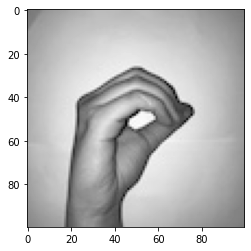

In [92]:
DATADIR = "/content/asl_dataset/"
CATEGORIES = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "unknown"]

for category in CATEGORIES:
    path = os.path.join(DATADIR,category)  # create path to categories
    for img in os.listdir(path):
      # iterate over each image
      # convert to array
      img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  
      plt.imshow(img_array, cmap='gray')  # graph it
      plt.show()  # display!

      break  # we just want one for now so break
    break  #...and one more!

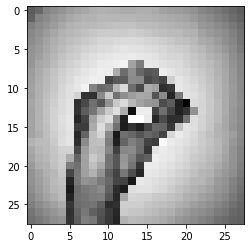

In [93]:
## We chose a standard size of 28 - this ensures prediction even under terrible quality
IMG_SIZE = 28

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap='gray')
plt.show() # Show resize image

##Set Training & Test Data

In [94]:
training_data = []

def create_training_data():
    for category in CATEGORIES:  # do 0,1,2,3, .....

        path = os.path.join(DATADIR,category)  # create path to categories
        class_num = CATEGORIES.index(category)  # get the classification

        for img in tqdm(os.listdir(path)):  # iterate over each image
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            
create_training_data() # call function

100%|██████████| 1815/1815 [00:01<00:00, 1607.74it/s]


## Shuffle the files

In [95]:
import random
random.shuffle(training_data)

# Check the shuffle
for sample in training_data[:10]:
    print(sample[1])


10
10
5
0
6
10
10
10
10
10


## Add the data into an X & Y list

X = features

Y = label

In [ ]:
X = []
Y = []

for features,label in training_data:
    X.append(features)
    Y.append(label)

print(X[0].reshape(-1, IMG_SIZE, IMG_SIZE, 1))

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

##Pickle the data

In [98]:
import pickle

pickle_out = open("/content/Kaggle/Working/X.pickle","wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("/content/Kaggle/Working/Y.pickle","wb")
pickle.dump(Y, pickle_out)
pickle_out.close()

In [99]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard
import time

import pickle

In [100]:
NAME = "Numbers-CNN-Model-{}".format(str(time.ctime())) # Model Name

In [101]:
# Load pickel data
pickle_in = open("/content/Kaggle/Working/X.pickle","rb")
X = pickle.load(pickle_in)
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

pickle_in = open("/content/Kaggle/Working/Y.pickle","rb")
Y = pickle.load(pickle_in)
Y = np.array(Y)

X = X/255.0

## Train the model

In [102]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense,Dropout,MaxPool2D,Conv2D

model = Sequential()
model.add(Conv2D(32,(3,3),padding = 'same',input_shape=X.shape[1:],activation = 'relu'))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(64,(3,3),padding = 'same',activation = 'relu'))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(128,(3,3),padding = 'same',activation = 'relu'))
model.add(MaxPool2D((2,2)))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dense(11,activation="softmax"))

tensorboard = TensorBoard(log_dir="/kaggle/working/logs/{}".format(NAME))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X, Y, batch_size=32, epochs=10, validation_split=0.2, callbacks=[tensorboard])

Epoch 1/10
115/115 [==============================] - 34s 15ms/step - loss: 1.8387 - accuracy: 0.4141 - val_loss: 1.2242 - val_accuracy: 0.5972
Epoch 2/10
115/115 [==============================] - 0s 4ms/step - loss: 1.0912 - accuracy: 0.6017 - val_loss: 0.5142 - val_accuracy: 0.8559
Epoch 3/10
115/115 [==============================] - 0s 4ms/step - loss: 0.4197 - accuracy: 0.8668 - val_loss: 0.3184 - val_accuracy: 0.8952
Epoch 4/10
115/115 [==============================] - 0s 4ms/step - loss: 0.2103 - accuracy: 0.9278 - val_loss: 0.2490 - val_accuracy: 0.9203
Epoch 5/10
115/115 [==============================] - 1s 4ms/step - loss: 0.1429 - accuracy: 0.9507 - val_loss: 0.2331 - val_accuracy: 0.9258
Epoch 6/10
115/115 [==============================] - 1s 5ms/step - loss: 0.1159 - accuracy: 0.9670 - val_loss: 0.1611 - val_accuracy: 0.9509
Epoch 7/10
115/115 [==============================] - 0s 4ms/step - loss: 0.0649 - accuracy: 0.9812 - val_loss: 0.1394 - val_accuracy: 0.9607
Epoc

## Model Summary


In [126]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0

##Training Conclusion
Overall the model has 99% Accuracy when predicting numbers

# Let's Test the model

In [104]:
# conversion function - turns the array result to the chosen digit
def testCNNModel(path,model):
    im1 =cv2.imread(path,0)
    im1 = cv2.resize(im1,(28,28))
    t = []
    t.append(im1.reshape(28,28))
    t = np.asarray(t)
    t = t.reshape(1,28,28,1)
    res = model.predict(t)
    for i in range(len(res[0])):
      if res[0][i]==1:
        if i == 10:
          return "Unknown"
        else:
          return i
    return "None"

### Test Digit: 0

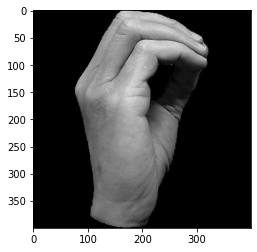

In [118]:
DATADIR = '/content/asl_dataset/0/hand1_0_dif_seg_1_cropped.jpeg'
img_array = cv2.imread(DATADIR,cv2.IMREAD_GRAYSCALE)  
plt.imshow(img_array, cmap='gray')  # graph it
plt.show()  # display!

In [113]:
testCNNModel('/content/asl_dataset/0/hand1_0_dif_seg_1_cropped.jpeg',model)

0

### Test Digit: 4

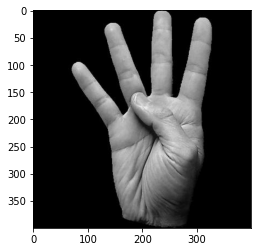

In [119]:
DATADIR = '/content/asl_dataset/4/hand1_4_dif_seg_1_cropped.jpeg'
img_array = cv2.imread(DATADIR,cv2.IMREAD_GRAYSCALE)  
plt.imshow(img_array, cmap='gray')  # graph it
plt.show()  # display!

In [115]:
testCNNModel('/content/asl_dataset/4/hand1_4_dif_seg_1_cropped.jpeg',model)

4

### Test Digit: 9

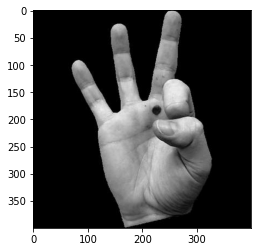

In [127]:
DATADIR = '/content/asl_dataset/9/hand3_9_dif_seg_1_cropped.jpeg'
img_array = cv2.imread(DATADIR,cv2.IMREAD_GRAYSCALE)  
plt.imshow(img_array, cmap='gray')  # graph it
plt.show()  # display!

In [128]:
testCNNModel('/content/asl_dataset/9/hand3_9_dif_seg_1_cropped.jpeg',model)

9

### Test Digit: unknown

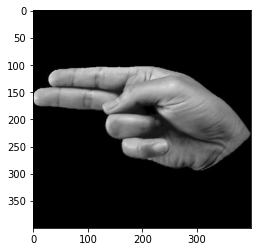

In [124]:
DATADIR = '/content/asl_dataset/unknown/hand2_h_left_seg_5_cropped.jpeg'
img_array = cv2.imread(DATADIR,cv2.IMREAD_GRAYSCALE)  
plt.imshow(img_array, cmap='gray')  # graph it
plt.show()  # display!

In [125]:
testCNNModel('/content/asl_dataset/unknown/hand2_h_left_seg_5_cropped.jpeg',model)

'Unknown'

# Last Organisation

Moving files locally to my Drive...

Should've set this up from the start

In [132]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [133]:
src = '/content/asl_dataset'
dest = '/content/drive/MyDrive/BGN_Data/Digits_folder/Dataset'

files = os.listdir(src)
 
for f in files:
    shutil.move(src+"/"+ f, dest)

# Save the model in the needed form - tfile

In [135]:
checkpoint_filepath = '/content/drive/MyDrive/BGN_Data/Digits_folder/Models/tflite'

In [ ]:
#model.save("/content/drive/MyDrive/BGN_Data/Digits_folder/Models/Other/{}.model".format(NAME))

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(f'{checkpoint_filepath[:-2]}tflite', 'wb').write(tflite_model)